# Save land-only XCO2 data
---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray
import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
DS_xco2 = xarray.open_dataset("../data/OCO2_Lite_XCO2.nc")
DS_xco2

<xarray.Dataset>
Dimensions:  (time: 182297008)
Coordinates:
    lon      (time) float32 ...
    lat      (time) float32 ...
  * time     (time) datetime64[ns] 2014-09-06T02:07:25.228014848 ... 2020-07-...
Data variables:
    xco2     (time) float32 ...

In [3]:
# Relabel lon-lat coords on 1-degree

# Establish grid
lon_bins = np.arange(-180, 180)
lat_bins = np.arange(-90, 90)
lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

# Assign grid labels
df_grid_xco2 = DS_xco2.to_dataframe().reset_index()
df_grid_xco2["lon_centers"] = pd.cut(df_grid_xco2.lon, lon_bins, labels=lon_centers).astype(float)
df_grid_xco2["lat_centers"] = pd.cut(df_grid_xco2.lat, lat_bins, labels=lat_centers).astype(float)

df_grid_xco2

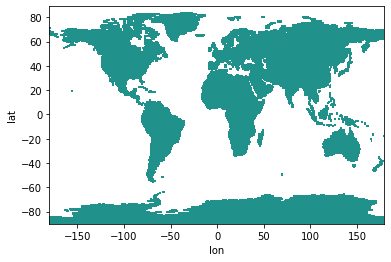

In [4]:
# Construct ocean mask
land = regionmask.defined_regions.natural_earth.land_110
mask = land.mask(lon_centers, lat_centers)
mask.plot(add_colorbar=False);

# df_mask = mask.to_dataframe().reset_index().rename(columns={"lon": "lon_centers", "lat": "lat_centers"})
# df_mask

In [5]:
mask

<xarray.DataArray 'region' (lat: 179, lon: 359)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5

In [33]:
# Merge land mask, drop ocean values, convert to dataset

DS_temp = (
    pd.merge(df_grid_xco2, df_mask, on=["lon_centers", "lat_centers"], how="left")
    .dropna(subset=["region"])
    .drop(columns=["lon_centers", "lat_centers", "region"])
    .set_index(["time"])
    .to_xarray()
)

DS_xco2_land = xarray.Dataset(
    {"xco2": (["time"], DS_temp.xco2),},
    coords={
        "lon": (["time"], DS_temp.lon),
        "lat": (["time"], DS_temp.lat),
        "time": DS_temp.time,
    },
)

DS_xco2_land

<xarray.Dataset>
Dimensions:  (time: 58844887)
Coordinates:
    lon      (time) float32 160.51178 160.50188 ... -104.92578 -104.92716
    lat      (time) float32 54.465744 54.48532 54.482136 ... 54.38092 54.38522
  * time     (time) datetime64[ns] 2014-09-06T02:07:25.228014848 ... 2020-07-...
Data variables:
    xco2     (time) float32 394.48465 392.93207 394.06973 ... 407.81757 407.105

In [34]:
DS_xco2_land.to_netcdf("../data/OCO2_Lite_XCO2_land.nc", format="NETCDF4")